In [1]:
%load_ext autoreload
%autoreload 2

# Add other paths
import os, sys
sys.path.append(os.path.abspath(os.path.join("../")))
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
import glob
import datetime as dt
from sklearn.metrics import r2_score
from tqdm.auto import tqdm

import helper_libraries.results_tools as results_tools

# Import Data

In [2]:
# Load returns and spreads
fret_df, hrf_df = results_tools.load_mkt_rf_returns()
spread_df = results_tools.load_spreads()

## Visualize

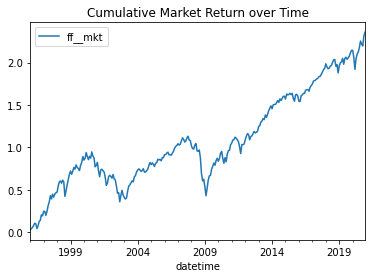

In [3]:
fret_df.groupby(pd.Grouper(freq = '1m')).sum().cumsum().plot()
plt.title('Cumulative Market Return over Time');

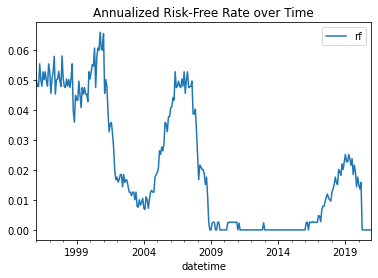

In [4]:
## Risk free
hrf_df.groupby(pd.Grouper(freq = '1m')).sum().pipe(lambda x: x*12).plot()
plt.title('Annualized Risk-Free Rate over Time');

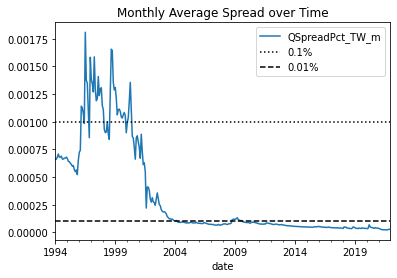

In [5]:
## Spreads
spread_df.groupby(pd.Grouper(freq = '1m')).mean().plot(y = 'QSpreadPct_TW_m')
plt.axhline(0.001, color = 'k', ls = ':', label = "0.1%")
plt.axhline(0.0001, color = 'k', ls = '--', label = "0.01%")
plt.legend()
plt.title('Monthly Average Spread over Time');

# Functions

In [6]:
def format_pd_latex_table(pd_latex_table, table_caption, table_fontsize, table_label, table_note):

    pd_latex_table = pd_latex_table.replace(r'\toprule', '\\toprule\n\\toprule')
    pd_latex_table = pd_latex_table.replace(r'\bottomrule', '\\bottomrule\n\\bottomrule')

    full_latex_table = (
        r"""
    \begin{table}[!h]
    """
        + "\\"
        + table_fontsize
        + r"""
    \centering
    \caption{"""
        + table_caption
        + r"""}
    \label{tab:"""
        + table_label
        + r"""}
    \begin{threeparttable}
    """
        + pd_latex_table
        + r"""\begin{tablenotes}[flushleft]
    \item\textit{Note:} """
        + table_note
    + r"""
    \end{tablenotes}
    \end{threeparttable}
    \end{table}
    """
    )
    
    # Get rid of extra spacing 
    full_latex_table = full_latex_table.replace('\n    ', '\n')

    return full_latex_table

In [7]:
def compute_rsquared(truth, pred):
    return 1 - np.sum(np.square(truth-pred))/np.sum(np.square(truth))

# Main - Hourly

## Params

In [27]:
## Params
# List of all results folders
results_folders = (
    pd.read_excel("../../results/key.xlsx").query('"Done" in Notes')["Folder"].to_list()
)  ##### <------------------ Finish models!
# Year to start trading
start_year = "2004"

# Define strategies and models
strategies_list = [
    "Market",
    "Sign",
    "Positive",
    "Tanh",
    "MS Strategy 2",
    "MS Strategy 1",
]
model_list = ["Benchmark", "LR", "LR_PCA_select", "LR_Lasso_select", "Lasso", "Enet"]

# Latex table params
table_loc = "!h"  # Should be something like htbp
table_fontsize = "footnotesize"
table_precaption = "Performance Results"
table_output_folder = "../../docs/exhibits/tables"

# Metrics and their names
metrics_list = ["Return", "ReturnAdj", "Sharpe", "SharpeAdj", "Trades", "rvol"]
metrics_names_list = [
    "Return",
    "Adjusted Return",
    "Sharpe",
    "Adjusted Sharpe",
    "Trades",
    "Realized Volatility",
]

In [9]:
## Aggregated data

# Daily average spread
spread_daily_df = spread_df.groupby(['symbol', pd.Grouper(freq = '1d')]).mean().reset_index().set_index('date')

# Daily returns
fret_daily_df = fret_df.groupby(pd.Grouper(freq = '1d')).sum()
hrf_daily_df = hrf_df.groupby(['date', pd.Grouper(freq = '1d')]).sum().reset_index().set_index('datetime')

In [10]:

## Get forecast data
forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
    folder_name='main_hour',
    debug=True,
)


# Model list?
model_list = [
    x.replace("oss_", "") for x in forecast_oss_df.columns if "NN" not in x
]  ###################### <----- Remove this !!

## Get trading results
# Filter data
forecast_oss_filter_df = forecast_oss_df.loc[start_year:].copy()
forecast_ins_filter_df = forecast_ins_df.loc[:str(int(start_year)-1)].copy()
fret_filter_df = fret_df.loc[start_year:].copy()
hrf_filter_df = hrf_df.loc[start_year:].copy()



# Trading strategies
(
    oss_results_all_df,
    oss_returns_all_df,
    oss_weights_all_df,
    oss_retpred_all_df,
) = results_tools.get_trading_results(
    forecast_oss_filter_df,
    forecast_ins_df,
    spread_df,
    fret_filter_df["ff__mkt"],
    hrf_filter_df["rf"],
    strategies_list,
    model_list,
    hold_cash=True,
)

## Sharpe

### No Transaction Costs

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

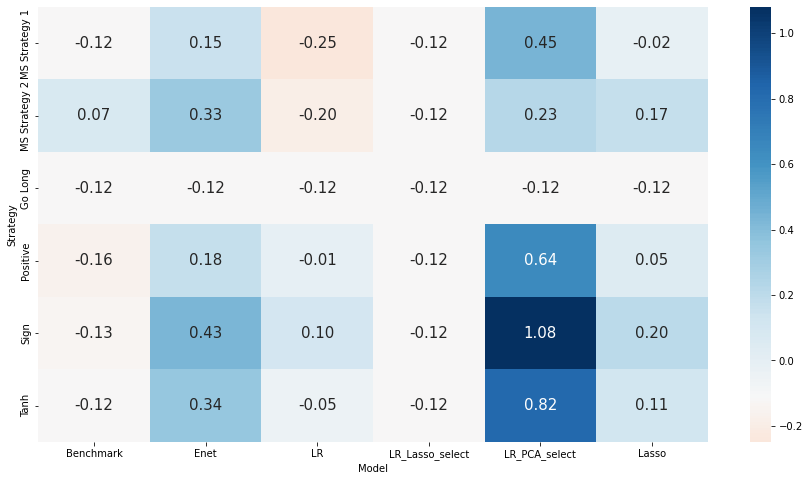

In [12]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="Sharpe")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df.rename(index = {"Market": "Go Long"}),
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".2f",
    annot=True,
    annot_kws={"fontsize": 15},
)

### Transaction Costs

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

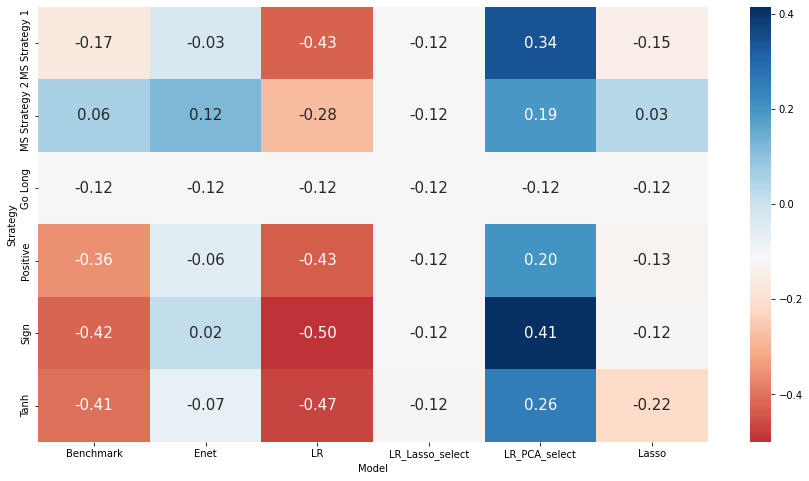

In [14]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="SharpeAdj")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df.rename(index = {"Market": "Go Long"}),
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".2f",
    annot=True,
    annot_kws={"fontsize": 15},
)

## Returns

### No Transaction Costs

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

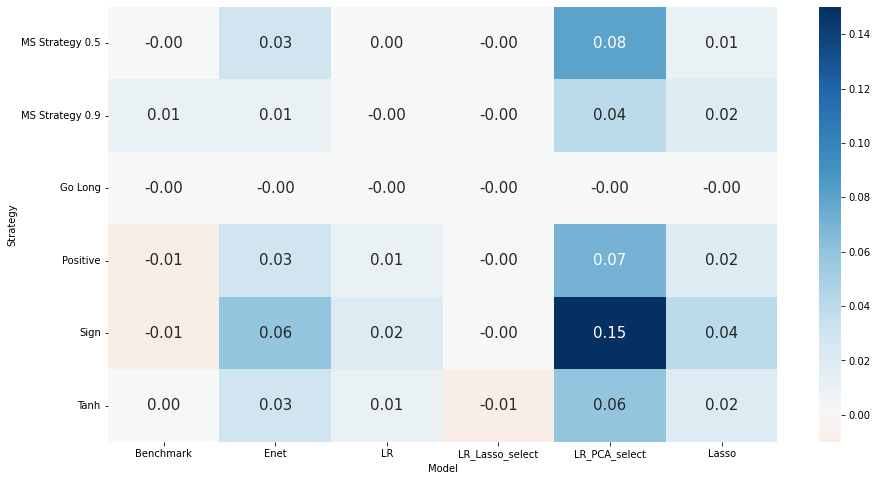

In [19]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="Return")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df.rename(index = {"Market": "Go Long"}),
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".2f",
    annot=True,
    annot_kws={"fontsize": 15},
)

### Transaction Costs

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

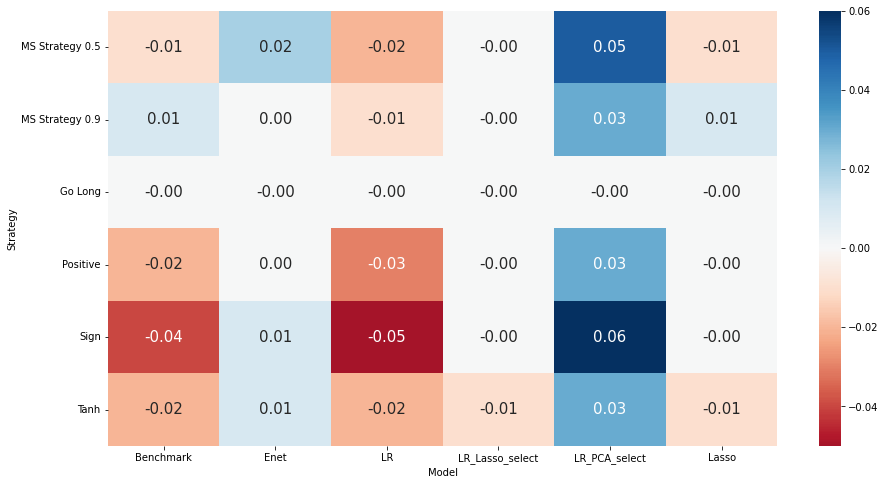

In [20]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="ReturnAdj")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df.rename(index = {"Market": "Go Long"}),
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".2f",
    annot=True,
    annot_kws={"fontsize": 15},
)

## Turnover

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

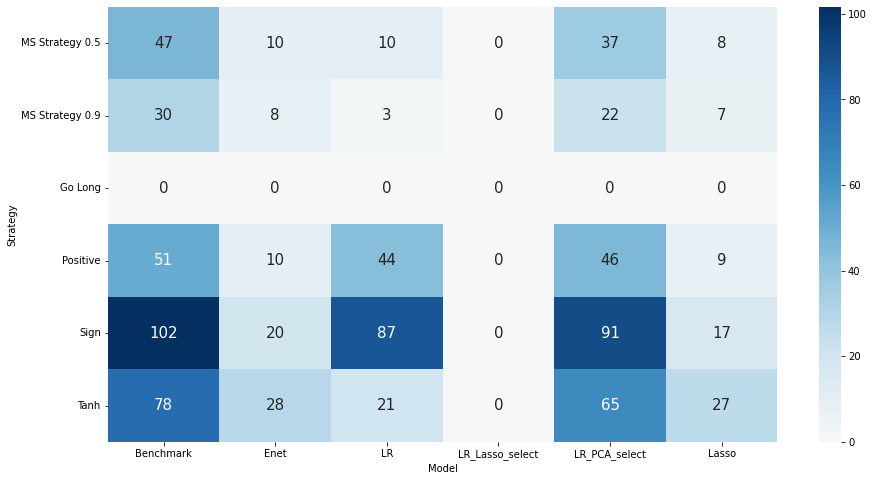

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/home/saketh/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3807, in atexit_operations
    self.history_manager.end_session()
  File "/home/saketh/.local/lib/python3.8/site-packages/IPython/core/history.py", line 576, in end_session
    self.db.execute("""UPDATE sessions SET end=?, num_cmds=? WHERE
sqlite3.OperationalError: disk I/O error


In [48]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="Trades")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df.rename(index = {"Market": "Go Long"}),
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".0f",
    annot=True,
    annot_kws={"fontsize": 15},
)

## Tables

In [29]:
folder_name = 'main_hourly'

### Produce latex tables
print("\\section{" + folder_name.replace("_", " ").title() + "}")

## Produce table for R2
# Get true values
forecast_oss_filter_df["truth"] = fret_filter_df["ff__mkt"]
forecast_ins_filter_df["truth"] = fret_filter_df["ff__mkt"]

# Set up dataframe with metrics
r2_metrics_df = pd.DataFrame([], index=model_list)

# Fill in R2 estimates
for col in model_list:
    r2_metrics_df.loc[col, "R2_ins"] = compute_rsquared(
        forecast_ins_filter_df["truth"], forecast_ins_filter_df["ins_" + col]
    )
    r2_metrics_df.loc[col, "R2_oss"] = compute_rsquared(
        forecast_oss_filter_df["truth"], forecast_oss_filter_df["oss_" + col]
    )

# Format results
r2_metrics_df = r2_metrics_df.applymap(lambda x: np.nan if np.abs(x) > 10 else x)
r2_metrics_df["R2_diff"] = r2_metrics_df["R2_oss"] - r2_metrics_df["R2_ins"]
r2_metrics_df.index = pd.MultiIndex.from_tuples(
    [(x.split("_")[0], " ".join(x.split("_")[1:2])) for x in r2_metrics_df.index]
).set_names(["Regression", "Selection"])

# Computed parameters
table_caption = table_precaption + ": R2"
table_label = table_precaption.lower().replace(" ", "_") + "_" + results_folder_name + "_R2"
table_note = (
    r"We report the in-sample and out-of-sample $R^2$s for each of our models. "
    + r"The first column states the model name while the second states the variable selection strategy. "
    + r"[[[[Rewrite this table note???]]]]"
)

# Get latex table from pandas
pd_latex_table = r2_metrics_df.reset_index().to_latex(
    index=False, multicolumn=False, sparsify=False
)

## Produce tables for each of the metrics

# Get pivotted dataframe with index being the strategy
# and columns being a muiltilevel consisting of (metric, model)
# Also format stratgies and models into a particular order
oss_results_all_fmt_df = oss_results_all_df.copy()
oss_results_all_fmt_df["Name"] = pd.Categorical(
    oss_results_all_fmt_df["Name"], categories=model_list, ordered=True
)
oss_results_all_fmt_df.index = pd.Categorical(
    oss_results_all_fmt_df.index, categories=strategies_list, ordered=True
)
pivot_allmetrics_df = oss_results_all_fmt_df.rename_axis(index="Strategy").pivot(
    columns="Name", values=metrics_list
)

# For each metric
for metric_idx, metric in enumerate(metrics_list):

    # Get pivot table for a particular metric
    pivot_metric_df = pivot_allmetrics_df[metric].copy()
    pivot_metric_df.columns = pd.MultiIndex.from_tuples(
        [(x.split("_")[0], " ".join(x.split("_")[1:2])) for x in pivot_metric_df.columns]
    ).set_names(["Regression", "Strategy/Selection"])

    # Convert to latex table
    if "return" in metric.lower():
        pd_latex_table = (
            pivot_metric_df.pipe(lambda x: x * 100)
            .rename_axis(index=None)
            .to_latex(float_format="%.2f", multicolumn=False, sparsify=False)
        )
    elif "trades" in metric.lower():
        n_years = (forecast_oss_filter_df.index.max() - forecast_oss_filter_df.index.min()).days / 365
        pd_latex_table = (
            (pivot_metric_df * n_years / len(forecast_oss_filter_df))
            .rename_axis(index=None)
            .to_latex(float_format="%.3f", multicolumn=False, sparsify=False)
        )
    else:
        pd_latex_table = pivot_metric_df.rename_axis(index=None).to_latex(
            float_format="%.2f", multicolumn=False, sparsify=False
        )

    # Computed parameters
    table_caption = table_precaption + ": " + metrics_names_list[metric_idx]
    table_label = (
        table_precaption.lower().replace(" ", "_")
        + "_"
        + results_folder_name
        + "_"
        + metric.lower()
    )
    table_note = r"We report the performance results for each of our models after passing their predictions through various trading strategies. Each model is defined by a regression and a variable selection procedure; both  are stated in the first two rows of each panel. Models with blank selection procedures simply pass all the regressors to the regression. The trading strategies are stated in the first column of each row containing results; the ``Market'' strategy refers to simply going long on the market. [[[[Rewrite this table note???]]]]"

    # Format pandas latex table nicely
    pd_latex_table_fmtd = format_pd_latex_table(
        pd_latex_table, table_caption, table_fontsize, table_label, table_note
    )

    # # Write to file
    # output_filename = (
    #     f"{table_output_folder}/trading_results_{results_folder_name}_{metric.lower()}.tex"
    # )
    # with open(output_filename, "w+") as f:
    #     f.write(pd_latex_table_fmtd)
    
    # Print
    print(pd_latex_table_fmtd)

    # # Print latex command
    # print("\\input{" + output_filename + "}")

print("\n\\clearpage\n")

\section{Main Hourly}

\begin{table}[!h]
\footnotesize
\centering
\caption{Performance Results: Return}
\label{tab:performance_results_main_hour_return}
\begin{threeparttable}
\begin{tabular}{lrrrrrr}
\toprule
\toprule
Regression & Benchmark &    LR &    LR &    LR & Lasso &  Enet \\
Strategy/Selection &           &       &   PCA & Lasso &       &       \\
\midrule
Market        &     -0.46 & -0.46 & -0.46 & -0.46 & -0.46 & -0.46 \\
Sign          &     -0.66 &  2.27 & 14.55 & -0.46 &  3.57 &  6.36 \\
Positive      &     -0.56 &  0.90 &  7.04 & -0.46 &  1.55 &  2.95 \\
Tanh          &      0.13 &  0.69 &  6.38 & -0.51 &  1.77 &  3.13 \\
MS Strategy 2 &      1.41 & -0.24 &  1.85 & -0.46 &  2.24 &  3.43 \\
MS Strategy 1 &      0.05 & -0.91 &  3.64 & -0.46 &  0.79 &  2.67 \\
\bottomrule
\bottomrule
\end{tabular}
\begin{tablenotes}[flushleft]
\item\textit{Note:} We report the performance results for each of our models after passing their predictions through various trading strategies. Each 

# Main - Daily

In [33]:
## Aggregated data

# Daily average spread
spread_daily_df = spread_df.groupby(['symbol', pd.Grouper(freq = '1d')]).mean().reset_index().set_index('date')

# Daily returns
fret_daily_df = fret_df.groupby(pd.Grouper(freq = '1d')).sum()
hrf_daily_df = hrf_df.groupby(['date', pd.Grouper(freq = '1d')]).sum().reset_index().set_index('datetime')

In [34]:
## Get forecast data
forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
    folder_name='main_daily',
    debug=True,
)


# Model list?
model_list = [
    x.replace("oss_", "") for x in forecast_oss_df.columns if "NN" not in x
]  ###################### <----- Remove this !!

## Get trading results
# Filter data
forecast_oss_filter_df = forecast_oss_df.loc[start_year:].copy()
forecast_ins_filter_df = forecast_ins_df.loc[:str(int(start_year-1))].copy()
fret_filter_df = fret_daily_df.loc[start_year:].copy()
hrf_filter_df = hrf_daily_df.loc[start_year:].copy()



# Trading strategies
(
    oss_results_all_df,
    oss_returns_all_df,
    oss_weights_all_df,
    oss_retpred_all_df,
) = results_tools.get_trading_results(
    forecast_oss_filter_df,
    forecast_ins_df,
    spread_df,
    fret_filter_df["ff__mkt"],
    hrf_filter_df["rf"],
    strategies_list,
    model_list,
    hold_cash=True,
)

## Tables

In [35]:
folder_name = 'main_daily'

### Produce latex tables
print("\\section{" + folder_name.replace("_", " ").title() + "}")

## Produce table for R2
# Get true values
forecast_oss_filter_df["truth"] = fret_filter_df["ff__mkt"]
forecast_ins_filter_df["truth"] = fret_filter_df["ff__mkt"]

# Set up dataframe with metrics
r2_metrics_df = pd.DataFrame([], index=model_list)

# Fill in R2 estimates
for col in model_list:
    r2_metrics_df.loc[col, "R2_ins"] = compute_rsquared(
        forecast_ins_filter_df["truth"], forecast_ins_filter_df["ins_" + col]
    )
    r2_metrics_df.loc[col, "R2_oss"] = compute_rsquared(
        forecast_oss_filter_df["truth"], forecast_oss_filter_df["oss_" + col]
    )

# Format results
r2_metrics_df = r2_metrics_df.applymap(lambda x: np.nan if np.abs(x) > 10 else x)
r2_metrics_df["R2_diff"] = r2_metrics_df["R2_oss"] - r2_metrics_df["R2_ins"]
r2_metrics_df.index = pd.MultiIndex.from_tuples(
    [(x.split("_")[0], " ".join(x.split("_")[1:2])) for x in r2_metrics_df.index]
).set_names(["Regression", "Selection"])

# Computed parameters
table_caption = table_precaption + ": R2"
table_label = table_precaption.lower().replace(" ", "_") + "_" + results_folder_name + "_R2"
table_note = (
    r"We report the in-sample and out-of-sample $R^2$s for each of our models. "
    + r"The first column states the model name while the second states the variable selection strategy. "
    + r"[[[[Rewrite this table note???]]]]"
)

# Get latex table from pandas
pd_latex_table = r2_metrics_df.reset_index().to_latex(
    index=False, multicolumn=False, sparsify=False
)

## Produce tables for each of the metrics

# Get pivotted dataframe with index being the strategy
# and columns being a muiltilevel consisting of (metric, model)
# Also format stratgies and models into a particular order
oss_results_all_fmt_df = oss_results_all_df.copy()
oss_results_all_fmt_df["Name"] = pd.Categorical(
    oss_results_all_fmt_df["Name"], categories=model_list, ordered=True
)
oss_results_all_fmt_df.index = pd.Categorical(
    oss_results_all_fmt_df.index, categories=strategies_list, ordered=True
)
pivot_allmetrics_df = oss_results_all_fmt_df.rename_axis(index="Strategy").pivot(
    columns="Name", values=metrics_list
)

# For each metric
for metric_idx, metric in enumerate(metrics_list):

    # Get pivot table for a particular metric
    pivot_metric_df = pivot_allmetrics_df[metric].copy()
    pivot_metric_df.columns = pd.MultiIndex.from_tuples(
        [(x.split("_")[0], " ".join(x.split("_")[1:2])) for x in pivot_metric_df.columns]
    ).set_names(["Regression", "Strategy/Selection"])

    # Convert to latex table
    if "return" in metric.lower():
        pd_latex_table = (
            pivot_metric_df.pipe(lambda x: x * 100)
            .rename_axis(index=None)
            .to_latex(float_format="%.2f", multicolumn=False, sparsify=False)
        )
    elif "trades" in metric.lower():
        n_years = (forecast_oss_filter_df.index.max() - forecast_oss_filter_df.index.min()).days / 365
        pd_latex_table = (
            (pivot_metric_df * n_years / len(forecast_oss_filter_df))
            .rename_axis(index=None)
            .to_latex(float_format="%.3f", multicolumn=False, sparsify=False)
        )
    else:
        pd_latex_table = pivot_metric_df.rename_axis(index=None).to_latex(
            float_format="%.2f", multicolumn=False, sparsify=False
        )

    # Computed parameters
    table_caption = table_precaption + ": " + metrics_names_list[metric_idx]
    table_label = (
        table_precaption.lower().replace(" ", "_")
        + "_"
        + results_folder_name
        + "_"
        + metric.lower()
    )
    table_note = r"We report the performance results for each of our models after passing their predictions through various trading strategies. Each model is defined by a regression and a variable selection procedure; both  are stated in the first two rows of each panel. Models with blank selection procedures simply pass all the regressors to the regression. The trading strategies are stated in the first column of each row containing results; the ``Market'' strategy refers to simply going long on the market. [[[[Rewrite this table note???]]]]"

    # Format pandas latex table nicely
    pd_latex_table_fmtd = format_pd_latex_table(
        pd_latex_table, table_caption, table_fontsize, table_label, table_note
    )

    # # Write to file
    # output_filename = (
    #     f"{table_output_folder}/trading_results_{results_folder_name}_{metric.lower()}.tex"
    # )
    # with open(output_filename, "w+") as f:
    #     f.write(pd_latex_table_fmtd)
    
    # Print
    print(pd_latex_table_fmtd)

    # # Print latex command
    # print("\\input{" + output_filename + "}")

print("\n\\clearpage\n")

\section{Main Daily}

\begin{table}[!h]
\footnotesize
\centering
\caption{Performance Results: Return}
\label{tab:performance_results_main_daily_return}
\begin{threeparttable}
\begin{tabular}{lrrrrrr}
\toprule
\toprule
Regression & Benchmark & Enet &   LR &    LR &   LR & Lasso \\
Strategy/Selection &           &      &      & Lasso &  PCA &       \\
\midrule
Market        &      9.69 & 9.69 & 9.69 &  9.69 & 9.69 &  9.69 \\
Sign          &      0.65 & 6.99 & 1.06 &  9.69 & 2.28 &  8.03 \\
Positive      &      5.17 & 8.34 & 5.38 &  9.69 & 5.98 &  8.86 \\
Tanh          &      4.24 & 7.54 & 2.97 &  9.68 & 4.51 &  7.82 \\
MS Strategy 2 &      2.47 & 7.26 & 5.48 &  9.69 & 1.45 & 10.62 \\
MS Strategy 1 &      5.56 & 9.03 & 6.09 &  9.69 & 5.18 &  8.78 \\
\bottomrule
\bottomrule
\end{tabular}
\begin{tablenotes}[flushleft]
\item\textit{Note:} We report the performance results for each of our models after passing their predictions through various trading strategies. Each model is defined by a re